In [1]:
import torch
from model.vae import VAE_denoiser
from model.loader_utils import *
from model.bigwig_handler import *
import matplotlib.pyplot as plt
import matplotlib.style as style

/hpcnfs/home/ieo5776/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# # CREATE TRAINING SET
# data = create_bedgraph('/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/marks/CTR_H2AUb1.bw', 
# 					   chip_dir='/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/marks/')

# # Save the output data for now to avoid computing this again
# data_flattened = np.concatenate([arr.ravel() for arr in data])
# np.save("/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/marks/ub1_array.npy",data_flattened)

In [3]:
# # CREATE TEST SET
# data = create_bedgraph('/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/marks/CTR_H3K27me3.bw', 
# 					   chip_dir='/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/marks/')

# # Save the output data for now to avoid computing this again
# data_flattened = np.concatenate([arr.ravel() for arr in data])
# np.save("/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/marks/me3_test.npy",data_flattened)

In [2]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model 
VAE = VAE_denoiser().to(device)
VAE

VAE_denoiser(
  (enc_layer1): Linear(in_features=1000, out_features=256, bias=True)
  (enc_layer2_mu): Linear(in_features=256, out_features=10, bias=True)
  (enc_layer2_logvar): Linear(in_features=256, out_features=10, bias=True)
  (dec_layer1): Linear(in_features=10, out_features=256, bias=True)
  (dec_layer2): Linear(in_features=256, out_features=1000, bias=True)
)

In [3]:
train_dataset = BigwWigdDataset(input_dir='/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/marks', 
								bg_file='ub1_array.npy')
test_dataset = BigwWigdDataset(input_dir='/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/marks', 
								bg_file='me3_test.npy')

train_DT = DataLoader(train_dataset, batch_size=128, shuffle=False, drop_last=True)
test_DT = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)

In [20]:
# initialize loss function and optimizer
adam = torch.optim.Adam(VAE.parameters(), lr=1e-3, weight_decay=1e-7)

losses_train, losses_test, kl_train, trained_model = train_test_model(train_DT=train_DT,
																		test_DT=test_DT,
																		model=VAE,
																		optimizer=adam,
																		device=device,
																		num_epochs=20)

#torch.save(trained_model, '/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/VAE_model.pth')

----> Epoch 1/20 | Loss_train: 962812.6617
--------> Loss_test: 60674699.4531
----> Epoch 2/20 | Loss_train: 495534.1552
--------> Loss_test: 50765853.4414
----> Epoch 3/20 | Loss_train: 552614.3048
--------> Loss_test: 42852160.0312
----> Epoch 4/20 | Loss_train: 520659.6479
--------> Loss_test: 31323612.9414
----> Epoch 5/20 | Loss_train: 538906.5253
--------> Loss_test: 50219992.0859
----> Epoch 6/20 | Loss_train: 474898.3149
--------> Loss_test: 27699788.3164
----> Epoch 7/20 | Loss_train: 530061.4702
--------> Loss_test: 29308922.8828
----> Epoch 8/20 | Loss_train: 478569.4779
--------> Loss_test: 32921977.7266
----> Epoch 9/20 | Loss_train: 451513.0533
--------> Loss_test: 27287617.5898
----> Epoch 10/20 | Loss_train: 484600.5226
--------> Loss_test: 51396073.7812
----> Epoch 11/20 | Loss_train: 513645.9131
--------> Loss_test: 39390427.8242
----> Epoch 12/20 | Loss_train: 423413.2042
--------> Loss_test: 24035551.0938
----> Epoch 13/20 | Loss_train: 420133.4513
--------> Loss_te

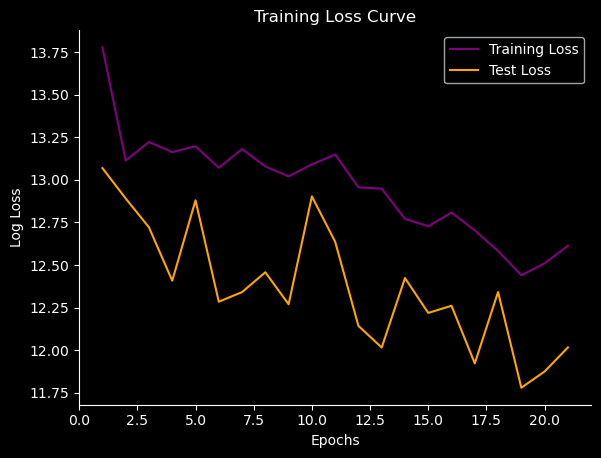

In [24]:
# Plotting the loss curve
style.use('dark_background')

fig, ax = plt.subplots()
num_epochs = len(losses_train)
plt.plot(range(1, num_epochs + 1), np.log(losses_train), label='Training Loss', color="purple")
plt.plot(range(1, num_epochs + 1), np.log(losses_test), label='Test Loss', color="orange")
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training Loss Curve')

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Reduce margin on the left and bottom
plt.subplots_adjust(left=0.1, bottom=0.1)

plt.legend()
plt.show()

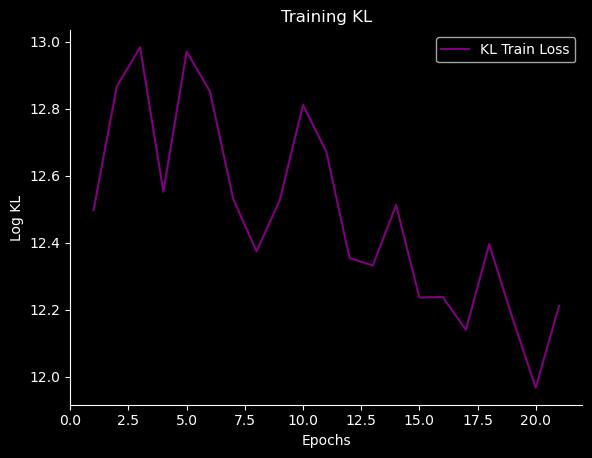

In [27]:
# Plotting the loss curve
style.use('dark_background')

fig, ax = plt.subplots()
num_epochs = len(kl_train)
plt.plot(range(1, num_epochs + 1), np.log(kl_train), label='KL Train Loss', color="purple")
plt.xlabel('Epochs')
plt.ylabel('Log KL')
plt.title('Training KL')

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Reduce margin on the left and bottom
plt.subplots_adjust(left=0.1, bottom=0.1)

plt.legend()
plt.show()

In [28]:
kl_train

[267563.78259277344,
 387254.27197265625,
 435079.49072265625,
 282694.26470947266,
 429550.96658325195,
 381520.7371520996,
 276805.6676940918,
 236602.43267822266,
 275498.7618255615,
 366385.8352661133,
 318824.75619506836,
 231857.3178024292,
 226832.18350219727,
 271696.5064544678,
 206119.45307922363,
 206498.77995300293,
 187166.96507263184,
 241732.0633392334,
 193898.3688812256,
 157470.2699546814,
 200960.089302063]

# TESTING

In [2]:
def _reshape_input(array):
		x = len(array)
		a, remainder = divmod(x, 1000)  # Assuming you want chunks of 1000 elements
		if remainder > 0:
			a += 1

		# Fill up the array to the required length
		pad_length = a * 10 * 100 - x
		padded_array = np.pad(array, (0, pad_length), mode='constant')

		# Reshape the array to the desired shape
		result_array = padded_array.reshape((a, 10, 100))

		return result_array

In [3]:
test = np.load('/hpcnfs/scratch/DP/amariani/Amariani/denoising_ChIPseq/data/tf/ring_array.npy')
test_reshaped =  _reshape_input(test)

In [8]:
test_torch = torch.from_numpy(test_reshaped[0])
  
# Step 3: Computing the mean, std and variance 
mean, std, var = torch.mean(test_torch), torch.std(test_torch), torch.var(test_torch) 
print("Mean, Std and Var before Normalize:\n",  
      mean, std, var) 
  
# Step 4: Normalizing the tensor 
test_torch  = (test_torch-mean)/std 
  
# Step 5: Again compute the mean, std and variance 
# after Normalize 
mean, std, var = torch.mean(test_torch), torch.std(test_torch), torch.var(test_torch) 
print("Mean, std and Var after normalize:\n",  
      mean, std, var)

Mean, Std and Var before Normalize:
 tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
Mean, std and Var after normalize:
 tensor(nan, dtype=torch.float64) tensor(nan, dtype=torch.float64) tensor(nan, dtype=torch.float64)


In [6]:
test_torch_2 = torch.from_numpy(test_reshaped[4000])
test_torch_2 = test_torch_2.view(-1)
  
# Step 3: Computing the mean, std and variance 
mean, std, var = torch.mean(test_torch_2), torch.std(test_torch_2), torch.var(test_torch_2) 
print("Mean, Std and Var before Normalize:\n",  
      mean, std, var) 
  
# Step 4: Normalizing the tensor 
test_torch_2  = (test_torch_2-mean)/std 
  
# Step 5: Again compute the mean, std and variance 
# after Normalize 
mean, std, var = torch.mean(test_torch_2), torch.std(test_torch_2), torch.var(test_torch_2) 
print("Mean, std and Var after normalize:\n",  
      mean, std, var)

Mean, Std and Var before Normalize:
 tensor(0.1321, dtype=torch.float64) tensor(0.1181, dtype=torch.float64) tensor(0.0140, dtype=torch.float64)
Mean, std and Var after normalize:
 tensor(1.1546e-17, dtype=torch.float64) tensor(1.0000, dtype=torch.float64) tensor(1.0000, dtype=torch.float64)


In [23]:
test_torch_3 = torch.from_numpy(test_reshaped[0])

In [10]:
x - min(x) / max(x) -min(x)

tensor(0.1321, dtype=torch.float64)

In [7]:
print(test_torch_3[0])
min = test_torch_3.min()
max = test_torch_3.max()
print(min)
print(max)

norm_tensor = ((test_torch_3) - min) / (max - min)
print(norm_tensor[0])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [47]:
a = torch.nn.Softmax(dim = 0)
b = a(test_torch_3.view(-1)).view(10,100)
b.sum()

tensor(1.0000, dtype=torch.float64)

In [52]:
test_array = [[1, 2, 3, 4],[20, 21, 21, 23]]

In [53]:
test_array[0] = test_array[0].append(5)
test_array[1] = test_array[1].append(24)

In [54]:
test_array

[None, None]